# Problem Sheet 4- The CUR factorization
**Submission until November 28 at 5 p.m. in the corresponding folder in StudIP.** \
In this exercise we consider the CUR decomposition as a special case of the CX decomposition. For a matrix $A \in \mathbb{R}^{m,n}$ it is defined as $$A \approx C U R$$ with $C \in \mathbb{R}^{m,k}$, $U \in \mathbb{R}^{k,k}$ and $R \in \mathbb{R}^{k,n}$. The important idea is that $C$ contains columns of $A$ and $R$ contains rows of $A$.



We choose $k$ as the number of columns and rows we want to use and store the column and the row indices as vectors $p$ and $q$, respectively. The first test will be with a simple 4 by 3 matrix.

**Task: Given $p$ and $q$ recall from the lecture how to compute the intersection matrix $U$ using left and right inverses $Y^\top = C^+, Z = R^+$ and complete the following code. (2 Points)**

In [1]:
import numpy as np

A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]])
k = 2
q = np.array([1, 2])
p = np.array([0, 3])

C =A[:,q] 
R =A[p,:]

I_P= np.identity(A.shape[0])
I_Q= np.identity(A.shape[1])
P =I_P[:,p]
Q =I_Q[q,:].T
Y_trans = (np.linalg.inv(P.T @ C))@ (P.T) #correction: this is not the definition of Y^T. you have to compute the left inverse of C
Z = Q @ (np.linalg.inv(R @ Q))  #correction: this is not the definition of Z you have to compute the right inverse of R
# U1  = np.linalg.inv(np.array([[5,8],[9,2]]))
U = Y_trans @ A @ Z
CUR = C @ U @ R

print(A)
print(CUR) 
#(-1.5 points)

[[1 5 8]
 [3 9 1]
 [4 5 4]
 [0 9 2]]
[[ 1.00000000e+00  5.00000000e+00  8.00000000e+00]
 [-1.45161290e-01  9.00000000e+00  1.00000000e+00]
 [ 4.19354839e-01  5.00000000e+00  4.00000000e+00]
 [ 1.11022302e-16  9.00000000e+00  2.00000000e+00]]


As you can see, we get an approximation of $A$, but we chose $p$ and $q$ randomly. In the following we want to implement the two heuristics for finding good values $p$ and $q$.  

The first heuristic is very simple - **leverage scores**.  Remember from the lecture that leverage scores are obtained via the truncated SVD.

**Task: Write a function that computes the row and column leverage scores and takes the matrix and a rank $k$ as input. The function should return the vectors $p$ and $q$. (4 Points)**

In [2]:
from scipy.sparse.linalg import svds, eigs

def leverageScores(A, k):
    norm_squared1 = []
    norm_squared2 = []
    U,_,V = svds(A,k=k)  
    for j in range (4):
        Uk=U[j, :]
        norm_squared1.append(np.linalg.norm(Uk)**2)
    for i in range (3):
        Vk=V[:,i]
        norm_squared2.append( np.linalg.norm(Vk)**2)
        
    p=np.argsort(norm_squared1)[-2:] #use -k instead of -2
    q=np.argsort(norm_squared2)[-2:] #use -k instead of -2 (-1 point)
    
    return p,q 

Test your function using the following code snippet. Note that the order of the indices is not important.

In [3]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
k = 2
p_correct = [0,1]
q_correct = [1,2]

p, q = leverageScores(A, k) #your function here

print("Your indices:")
print("p = ", p)
print("q = ", q)

print("Correct indices:")
print("p = ", p_correct)
print("q = ", q_correct)

Your indices:
p =  [1 0]
q =  [1 2]
Correct indices:
p =  [0, 1]
q =  [1, 2]


**Task: Combine our previous work to a CUR_leverage method that computes the CUR approximaton via leverage scores. (4 Points)** The function head should look like this:

```
CUR_leverage(A, k)
```
The function should return the three matrices $C$, $U$, and $R$.



In [6]:
def CUR_leverage(A, k):
    """
    Compute the CUR decomposition using leverage scores.

    Parameters:
    - A: Input matrix
    - k: Rank for truncated SVD

    Returns:
    - C: Matrix containing selected columns of A
    - U: Intersection matrix obtained from leverage scores
    - R: Matrix containing selected rows of A
    """
    # Compute leverage scores
    p, q = leverageScores(A, k)


    # Select columns specified by top_p_indices and store them in C
    C = A[:,q]

    # Select rows specified by top_q_indices and store them in R
    R = A[p,:]

    # Compute the intersection matrix U using left and right inverses
    I_P= np.identity(A.shape[0])
    I_Q= np.identity(A.shape[1])
    P =I_P[:,p]
    Q =I_Q[q,:].T
    Y_trans = (np.linalg.inv(P.T @ C))@ (P.T) #correction: same like above
    Z = Q @ (np.linalg.inv(R @ Q))  #correction: same like above
    # U1  = np.linalg.inv(np.array([[5,8],[9,2]]))
    U = Y_trans @ A @ Z
    return C, U, R

Let's look at the absolute and relative $\ell_2$ error.

In [7]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
C, U, R = CUR_leverage(A, 2)
print("absolute error: ", np.linalg.norm(A - (C@U@R)))
print("relative error: ", np.linalg.norm(A - (C@U@R))/np.linalg.norm(A))

absolute error:  3.9306190472874176
relative error:  0.2187054941538068


### Points 7.5/10

Now, we want to implement the second heuristic based on projections. 

**Task: Implement the algorithm based on projections to compute $p$ from the lecture and use the same concept to implement an algorithm for $q$. (4 Points)**

In [8]:
def interpolation(A, k): 
    a=A[:,0]
    p1=np.argmax(a)
    p=[p1]
    for j in range (1,A.shape[1]):
        a=A[:,j]
        I_P= np.identity(A.shape[0])
        P=A[:,range(j)]@(np.linalg.inv(I_P[:,range(j)].T @ A[:,range(j)]))@I_P[:,range(j)].T
        r=a- (P@a)
        p.append(np.argmax(np.abs(r)))
    V=A.T
    v=V[:,0]
    q1=np.argmax(v)
    q=[q1]
    for j in range (1,V.shape[1]):
        v=V[:,j]
        I_P= np.identity(V.shape[0])
        P=V[:,range(j)]@(np.linalg.inv(I_P[:,range(j)].T @ V[:,range(j)]))@I_P[:,range(j)].T
        r1=v- (P@v)
        q.append(np.argmax(np.abs(r1))) 
    q=list(set(q))[:k]
    p=list(set(p))[:k]
    return p, q

Test the algorithm on the following example as before.

In [9]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
k = 2
p_correct = [0,1]
q_correct = [1,2]

p, q = interpolation(A, k) #your function here

print("Your indices:")
print("p = ", p)
print("q = ", q)

print("Correct indices:")
print("p = ", p_correct)
print("q = ", q_correct) #you do not obtain the right result(-1 point) 

Your indices:
p =  [2, 3]
q =  [1, 2]
Correct indices:
p =  [0, 1]
q =  [1, 2]


**Task: Combine our previous work to a CUR_interpolation method that computes the CUR approximaton via the projection approach. (4 Points)** The function head should look like this:

```
CUR_interpolation(A, k)
```
The function should return the three matrices $C$, $U$, and $R$.

In [10]:
def CUR_interpolation(A, k):
    p, q = interpolation(A, k)
    C = A[:,q]

    # Select rows specified by top_q_indices and store them in R
    R = A[p,:]

    # Compute the intersection matrix U using left and right inverses
    I_P= np.identity(A.shape[0])
    I_Q= np.identity(A.shape[1])
    P =I_P[:,p]
    Q =I_Q[q,:].T
    Y_trans = (np.linalg.inv(P.T @ C))@ (P.T)
    Z = Q @ (np.linalg.inv(R @ Q))  
    U = Y_trans @ A @ Z
    return C, U, R

Let's look at the absolute and relative $\ell_2$ error.

In [147]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
C, U, R = CUR_interpolation(A, 2)
print("absolute error: ", np.linalg.norm(A - (C@U@R)))
print("relative error: ", np.linalg.norm(A - (C@U@R))/np.linalg.norm(A))

absolute error:  9.598446619885578
relative error:  0.534071856330042


### Points 7/8

# Applications

Having implemented both CUR variants, we want to apply and compare them on different examples. The first example is an RGB image of a baboon that we transform into a grayscale image to make it applicable to a CUR decomposition. Execute the following code to visualize the original image and the two CUR approximations. Which one looks better? (1 Point)

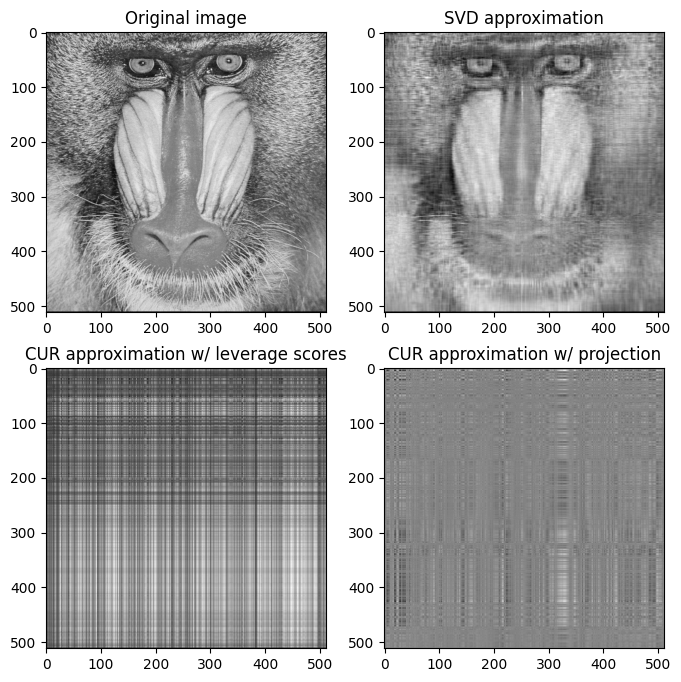

In [148]:
# /kaggle/input/baboon/baboon.png
# /kaggle/input/supreme-court/supreme_court.csv

from PIL import Image
import matplotlib.pyplot as plt

k = 20

im = np.asarray(Image.open('/kaggle/input/baboon/baboon.png').convert('L'), dtype=float)

U, S, Vt = svds(im, k=k)

C1, U1, R1 = CUR_leverage(im,k)
C2, U2, R2 = CUR_interpolation(im,k)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Original image')
plt.imshow(im, cmap='gray')
plt.subplot(222)
plt.imshow((U@np.diag(S)@Vt), cmap='gray')
plt.title('SVD approximation')
plt.subplot(223)
plt.imshow((C1@U1@R1), cmap='gray')
plt.title('CUR approximation w/ leverage scores')
plt.subplot(224)
plt.imshow((C2@U2@R2), cmap='gray')
plt.title('CUR approximation w/ projection')
plt.show()

Apply the CUR factorization to the supreme court data set. Execute the following code and compare the results. (1 Point)

In [149]:
import pandas as pd

k = 2

c = pd.read_csv('/kaggle/input/supreme-court/supreme_court.csv')
A = c.to_numpy().astype(float)
(m, n) = A.shape

U, S, Vt = svds(A, k=k)

C1, U1, R1 = CUR_leverage(A,k)
C2, U2, R2 = CUR_interpolation(A,k)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(A, cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('Original image')
plt.subplot(222)
plt.imshow((U@np.diag(S)@Vt), cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('SVD approximation')
plt.subplot(223)
plt.imshow((C1@U1@R1), cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('CUR approximation w/ leverage scores')
plt.subplot(224)
plt.imshow((C2@U2@R2), cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('CUR approximation w/ interpolation')
plt.show()

LinAlgError: Singular matrix

In [ ]:
A_svd = (U@np.diag(S)@Vt)
A_svd_01 = A_svd.copy()
A_svd_01[A_svd_01>=0.5] = 1
A_svd_01[A_svd_01<1] = 0

A_cur1 = (C1@U1@R1)
A_cur1_01 = A_cur1.copy()
A_cur1_01[A_cur1_01>=0.5] = 1
A_cur1_01[A_cur1_01<1] = 0

A_cur2 = (C2@U2@R2)
A_cur2_01 = A_cur2.copy()
A_cur2_01[A_cur2_01>=0.5] = 1
A_cur2_01[A_cur2_01<1] = 0

print("SVD approximation: ", 1. - np.count_nonzero(np.sum(np.abs(A-A_svd_01), axis=1)) / A.shape[0])
print("CUR approximation (leverage scores): ", 1. - np.count_nonzero(np.sum(np.abs(A-A_cur1_01), axis=1)) / A.shape[0])
print("CUR approximation (interpolation): ", 1. - np.count_nonzero(np.sum(np.abs(A-A_cur2_01), axis=1)) / A.shape[0])

### Points 0/2

## Total Points 14.5/20